In [1]:
#!pip install praw 
#!pip install squarify 
#!pip install emoji
#!pip install pyfolio

In [2]:
import praw
from data import *
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import squarify
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import emoji    # removes emojis
import re   # removes links
import en_core_web_sm
import string
import yfinance as yf
import pyfolio as pf
from datetime import date
from datetime import timedelta
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def data_extractor(reddit):
    '''extracts all the data from reddit
    Parameter: reddt: reddit obj
    Return:    posts, c_analyzed, tickers, titles, a_comments, picks, subs, picks_ayz
                
                posts: int: # of posts analyzed
                 c_analyzed: int: # of comments analyzed
                 tickers: dict: all the tickers found
                titles: list: list of the title of posts analyzed 
                 a_comments: dict: all the comments to analyze
                 picks: int: top picks to analyze
                 subs: int: # of subreddits analyzed
                picks_ayz: int: top picks to analyze
    
    '''
    
    '''############################################################################'''
    # set the program parameters
    subs = ['wallstreetbets','stocks' ]     # sub-reddit to search
    post_flairs = {'Daily Discussion', 'Weekend Discussion', 'Discussion'}    # posts flairs to search || None flair is automatically considered
    goodAuth = {'AutoModerator'}   # authors whom comments are allowed more than once
    uniqueCmt = True                # allow one comment per author per symbol
    ignoreAuthP = {'example'}       # authors to ignore for posts 
    ignoreAuthC = {'example'}       # authors to ignore for comment 
    upvoteRatio = 0.70         # upvote ratio for post to be considered, 0.70 = 70%
    ups = 20       # define # of upvotes, post is considered if upvotes exceed this #
    limit = 1     # define the limit, comments 'replace more' limit
    upvotes = 2     # define # of upvotes, comment is considered if upvotes exceed this #
    picks = 5     # define # of picks here, prints as "Top ## picks are:"
    picks_ayz = 5   # define # of picks for sentiment analysis
    '''############################################################################'''     
    
    posts, count, c_analyzed, tickers, titles, a_comments = 0, 0, 0, {}, [], {}
    cmt_auth = {}
    
    for sub in subs:
        subreddit = reddit.subreddit(sub)
        hot_python = subreddit.hot()    # sorting posts by hot
        # Extracting comments, symbols from subreddit
        for submission in hot_python:
            flair = submission.link_flair_text 
            author = submission.author.name         
            
            # checking: post upvote ratio # of upvotes, post flair, and author 
            if submission.upvote_ratio >= upvoteRatio and submission.ups > ups and (flair in post_flairs or flair is None) and author not in ignoreAuthP:   
                submission.comment_sort = 'new'     
                comments = submission.comments
                titles.append(submission.title)
                posts += 1
                try: 
                    submission.comments.replace_more(limit=limit)   
                    for comment in comments:
                        # try except for deleted account?
                        try: auth = comment.author.name
                        except: pass
                        c_analyzed += 1
                        
                        # checking: comment upvotes and author
                        if comment.score > upvotes and auth not in ignoreAuthC:      
                            split = comment.body.split(" ")
                            for word in split:
                                word = word.replace("$", "")        
                                # upper = ticker, length of ticker <= 5, excluded words,                     
                                if word.isupper() and len(word) <= 5 and word not in blacklist and word in us:
                                    
                                    # unique comments, try/except for key errors
                                    if uniqueCmt and auth not in goodAuth:
                                        try: 
                                            if auth in cmt_auth[word]: break
                                        except: pass
                                        
                                    # counting tickers
                                    if word in tickers:
                                        tickers[word] += 1
                                        a_comments[word].append(comment.body)
                                        cmt_auth[word].append(auth)
                                        count += 1
                                    else:                               
                                        tickers[word] = 1
                                        cmt_auth[word] = [auth]
                                        a_comments[word] = [comment.body]
                                        count += 1   
                except Exception as e: print(e)
                
                           
    return posts, c_analyzed, tickers, titles, a_comments, picks, subs, picks_ayz

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
def print_helper(tickers, picks, c_analyzed, posts, subs, titles, time, start_time):
    '''prints out top tickers, and most mentioned tickers
    
    Parameter:   tickers: dict: all the tickers found
                 picks: int: top picks to analyze
                 c_analyzed: int: # of comments analyzed
                 posts: int: # of posts analyzed
                 subs: int: # of subreddits analyzed
                titles: list: list of the title of posts analyzed 
                 time: time obj: top picks to analyze
                start_time: time obj: prog start time

    Return: symbols: dict: dict of sorted tickers based on mentions
            times: list: include # of time top tickers is mentioned
            top: list: list of top tickers
    '''    

    # sorts the dictionary
    symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse = True))
    top_picks = list(symbols.keys())[0:picks]
    time = (time.time() - start_time)
    
    # print top picks
    print("It took {t:.2f} seconds to analyze {c} comments in {p} posts in {s} subreddits.\n".format(t=time, c=c_analyzed, p=posts, s=len(subs)))
    print("Posts analyzed saved in titles")
    #for i in titles: print(i)  # prints the title of the posts analyzed
    
    
    print(f"\n{picks} most mentioned tickers: ")
    times = []
    top = []
    for i in top_picks:
        print(f"{i}: {symbols[i]}")
        times.append(symbols[i])
        top.append(f"{i}: {symbols[i]}")
   
    return symbols, times, top
    

In [4]:
#pip install pyfolio

In [5]:
    
def sentiment_analysis(picks_ayz, a_comments, symbols):
    '''analyzes sentiment anaylsis of top tickers
    
    Parameter:   picks_ayz: int: top picks to analyze
                 a_comments: dict: all the comments to analyze
                 symbols: dict: dict of sorted tickers based on mentions
    Return:      scores: dictionary: dictionary of all the sentiment analysis

    '''
    scores = {}
     
    vader = SentimentIntensityAnalyzer()
    vader.lexicon.update(new_words)     # adding custom words from data.py 
    picks_sentiment = list(symbols.keys())[0:picks_ayz]
    
    for symbol in picks_sentiment:
        stock_comments = a_comments[symbol]
        for cmnt in stock_comments:
    
            emojiless = emoji.get_emoji_regexp().sub(u'', cmnt) # remove emojis
            
            # remove punctuation
            text_punc  = "".join([char for char in emojiless if char not in string.punctuation])
            text_punc = re.sub('[0-9]+', '', text_punc)
                
            # tokenizeing and cleaning 
            tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|http\S+')
            tokenized_string = tokenizer.tokenize(text_punc)
            lower_tokenized = [word.lower() for word in tokenized_string] # convert to lower case
            
            # remove stop words
            nlp = en_core_web_sm.load()
            stopwords = nlp.Defaults.stop_words
            sw_removed = [word for word in lower_tokenized if not word in stopwords]
            
            # normalize the words using lematization
            lemmatizer = WordNetLemmatizer()
            lemmatized_tokens = ([lemmatizer.lemmatize(w) for w in sw_removed])
            
            # calculating sentiment of every word in comments n combining them
            score_cmnt = {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
            
            word_count = 0
            for word in lemmatized_tokens:
                if word.upper() not in us:
                    score = vader.polarity_scores(word)
                    word_count += 1
                    for key, _ in score.items():
                        score_cmnt[key] += score[key]    
                else:
                    score_cmnt['pos'] = 2.0               
                    
            # calculating avg.
            try:        # handles: ZeroDivisionError: float division by zero
                for key in score_cmnt:
                    score_cmnt[key] = score_cmnt[key] / word_count
            except: pass
                
            
            # adding score the the specific symbol
            if symbol in scores:
                for key, _ in score_cmnt.items():
                    scores[symbol][key] += score_cmnt[key]
            else:
                scores[symbol] = score_cmnt        
    
        # calculating avg.
        for key in score_cmnt:
            scores[symbol][key] = scores[symbol][key] / symbols[symbol]
            scores[symbol][key]  = "{pol:.3f}".format(pol=scores[symbol][key])
            
    return scores

In [6]:
def sentiment(scores,picks_ayz):
    print(f"\nSentiment analysis of top {picks_ayz} picks:")
    df = pd.DataFrame(scores)
    df.index = ['Bearish', 'Neutral', 'Bullish', 'Total/Compound']
    df = df.T
    print(df)

In [7]:
def visualization(picks_ayz, scores, picks, times, top):
    '''prints sentiment analysis
       makes a most mentioned picks chart
       makes a chart of sentiment analysis of top picks
       
    Parameter:   picks_ayz: int: top picks to analyze
                 scores: dictionary: dictionary of all the sentiment analysis
                 picks: int: most mentioned picks
                times: list: include # of time top tickers is mentioned
                top: list: list of top tickers
    Return:       None
    '''
    
    # printing sentiment analysis 
    print(f"\nSentiment analysis of top {picks_ayz} picks:")
    df = pd.DataFrame(scores)
    df.index = ['Bearish', 'Neutral', 'Bullish', 'Total/Compound']
    df = df.T
    print(df)
    
    # Date Visualization
    # most mentioned picks    
    squarify.plot(sizes=times, label=top, alpha=.7 )
    plt.axis('off')
    plt.title(f"{picks} most mentioned picks")
    #plt.show()
    
    # Sentiment analysis
    df = df.astype(float)
    colors = ['red', 'springgreen', 'forestgreen', 'coral']
    df.plot(kind = 'bar', color=colors, title=f"Sentiment analysis of top {picks_ayz} picks:")
    
    
    #plt.show()

In [8]:
def SMA(data,period=30,column='Close'):
    return data[column].rolling(window=period).mean()
def EMA(data,period=20,column='Close'):
    return data[column].ewm(span=period,adjust=False).mean()

In [9]:
def StockPrice(symbols):
    '''prints data frame  
    Parameter:   symbols
    Return:       data frame for top 5 sentiment analys stock price 
    '''
    today_date = date.today()
    three_Month = str(today_date -  timedelta(days=90))
    period_long =26
    period_short = 12
    period_signal = 9
    month_period = 30
    sma_period = 30
    #five = symbols.item()
    top_5 = list(symbols.keys())[0:5]
    df_price = pd.DataFrame()
    
    for i in top_5:
        i_data = yf.download(tickers= i, start=three_Month, end=today_date,interval='1d')
        i_out_data = i_data.drop(columns = ['Open','High','Low','Adj Close','Volume'])
        i_out_data.rename(columns={'Close':i},inplace=True)
        
        delta = i_out_data[i].diff(1)
        delta = delta[1:]
        up = delta.copy()
        down = delta.copy()
        up[up<0] = 0
        down[down>0]=0
        i_out_data['UP'] = up
        i_out_data['down'] = down
        AVG_Gain = SMA(i_out_data,month_period,column = 'UP')
        AVG_Loss = abs(SMA(i_out_data,month_period,column = 'down'))
        RS = AVG_Gain / AVG_Loss
        RSI = 100.0 - (100.0/(1.0 + RS))
        i_out_data['RSI'] =  RSI
        i_out_data = i_out_data.drop(columns = ['UP','down'])
        ShortEMA = EMA(i_out_data,period_short,column=i)
        LongEMA = EMA(i_out_data,period_long,column = i)
        i_out_data['MACD'] = ShortEMA - LongEMA
        i_out_data['Signal_Line'] = EMA(i_out_data, period_signal ,column ='MACD')
        i_out_data['SMA_30'] = SMA(i_out_data,sma_period,column=i)
        std = i_out_data['SMA_30'].rolling(window=30).std()
        i_out_data['Upper_Band'] = i_out_data['SMA_30']+std*2
        i_out_data['lower_Band'] = i_out_data['SMA_30']-std*2
        i_out_data['Prediction_close'] = i_out_data[[i]].shift(+1)
        i_out_data['Pct_change'] = i_out_data[[i]].pct_change(+1)       
        #print(i_out_data.head())
        df_price = pd.concat([i_out_data,df_price], axis='columns', join='outer', ignore_index = False)
        df_price.dropna(inplace = True)
        print(df_price.head())
        
        X = df_price.drop(columns=['Prediction_close','Pct_change'])
        print(X)
        y = df_price['Prediction_close'].copy()
    
        X_lr = df_price.drop(columns=['Prediction_close','Pct_change'])
        y_lr = df_price['Pct_change'].copy()
        
        
        

        
        lenght_lr = int(round(len(X)*.5,0))
        X_train_lr = X[:lenght_lr]
        X_test_lr = X[lenght_lr:]
        y_train_lr =y[:lenght_lr]
        y_test_lr = y[lenght_lr:]
        
        length = int(round(len(X)*.5,0))
        X_train = X[:length]
        X_test = X[length:]
        y_train = y[:length]
        y_test = y[length:]

        lr = LinearRegression().fit(X_train_lr, y_train_lr)
        prediction_lr = lr.predict(X_test_lr)
        results_df_lr = pd.DataFrame({'Real':y_test_lr, 'Predictions':prediction_lr})
        results_df_lr['Real Buy/Sell'] = np.where(results_df_lr['Real']>=0,'Sell','Buy')
        results_df_lr['Predict Buy/Sell'] = np.where(results_df_lr['Predictions']>=0,'Sell','Buy')
        results_df_lr['Model test'] = np.where(results_df_lr['Real Buy/Sell']==results_df_lr['Predict Buy/Sell'],1,0)
        
        print(f"Linear result :{results_df_lr}")
        print(f"Linear prediction :{prediction_lr[:5]}")
        print(f"linear result :{y_test_lr[:5]}")
        #plt.scatter(X_test_lr, y_test_lr)
        #plt.plot(X_test_lr, prediction_lr, color='red')
        
        score_lr = lr.score(X_lr,y_lr)
        r2_lr = r2_score(y_test_lr,prediction_lr)
        mse_lr = mean_squared_error(y_test_lr,prediction_lr)
        print(f"Linear regression score:{score_lr}, r2_lr:{r2_lr}, mse_lr={mse_lr}")
        
        
        tree = DecisionTreeRegressor().fit(X_train,y_train)
        prediction = tree.predict(X_test)
        results_df = pd.DataFrame({'Real':y_test, 'Predictions':prediction})
        results_df['Real Buy/Sell'] = np.where(results_df['Real']>=0,'Sell','Buy')
        results_df['Predict Buy/Sell'] = np.where(results_df['Predictions']>=0,'Sell','Buy')
        results_df['Model test'] = np.where(results_df['Real Buy/Sell']==results_df['Predict Buy/Sell'],1,0)
        
        print(f"Decision Tree :{results_df}")        
        print(f"Decision Tree prediction : {prediction[:5]}")
        print(f"Decision Tree result :{y_test[:5]}")
        
        score = tree.score(X ,y)
        r2 = r2_score(y_test, prediction)
        mse = mean_squared_error(y_test, prediction)
        print(f"Desicon Tree :{score}, r2:{r2}, mse = {mse}")
        
        #df[i] = list(i_out_data)
        #df.append(i_out_data)
        #df_price.dropna(inplace = True)
        df_price = pd.DataFrame()

In [10]:
#StockPrice(symbols)

It took 45.88 seconds to analyze 2775 comments in 29 posts in 2 subreddits.

Posts analyzed saved in titles

5 most mentioned tickers: 
BABA: 24
PLTR: 17
GME: 14
AAPL: 11
TSLA: 11
[*********************100%***********************]  1 of 1 completed
                  BABA        RSI      MACD  Signal_Line      SMA_30  \
Date                                                                   
2021-08-11  194.860001  35.087104 -4.165478    -4.132663  204.751666   
2021-08-12  191.660004  34.924442 -4.361855    -4.178501  203.581000   
2021-08-13  188.619995  35.494275 -4.708511    -4.284503  202.472666   
2021-08-16  182.710007  34.948446 -5.397902    -4.507183  201.304667   

            Upper_Band  lower_Band  Prediction_close  Pct_change  
Date                                                              
2021-08-11  211.330235  198.173097        195.729996   -0.004445  
2021-08-12  210.811411  196.350589        194.860001   -0.016422  
2021-08-13  210.360248  194.585085        191.6600

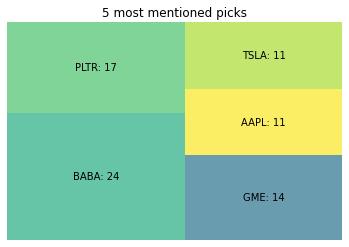

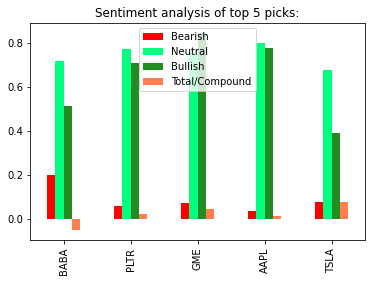

In [11]:
def main():
    '''main function
    Parameter:   None
    Return:       None
    '''
    start_time = time.time()
    
    # reddit client
    reddit = praw.Reddit(user_agent="Comment Extraction",
                         client_id="VpHhcn4Pt6u42DfPBnbOrQ",
                         client_secret="YOFjc2YV0z3vxx0dU_eAT55VjprgJQ",
                         username="ayushshah1204",
                         password="Ayush@1204")

    posts, c_analyzed, tickers, titles, a_comments, picks, subs, picks_ayz = data_extractor(reddit)
    symbols, times, top = print_helper(tickers, picks, c_analyzed, posts, subs, titles, time, start_time)
    scores = sentiment_analysis(picks_ayz, a_comments, symbols)
    stock_price = StockPrice(symbols)
    sentiment(scores,picks_ayz)
    visualization(picks_ayz, scores, picks, times, top)
    return stock_price
    
if __name__ == '__main__':
   df =  main()
 

In [12]:
#put them in a datafame
df.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:
#